### Criando Preços para simular o uso na GetNet

In [1]:
# Libs iniciais / pacote padrão
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import shapiro, kstest, normaltest, anderson, probplot

# Desativar avisos de expiração
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np

# Definindo o número de clientes
num_clientes = 1000

# Criando os dados aleatórios
clientes = ['cliente ' + str(i) for i in range(1, num_clientes + 1)]
valores = np.random.randint(50, 10001, size=num_clientes)  # Valores aleatórios de 50 a 10000

# Criando o DataFrame
df = pd.DataFrame({'cliente': clientes, 'valor': valores})


# Adicionando a coluna 'Gasto' com valores de 3% a 8% da coluna 'Valor'
df['gasto'] = df['valor'] * np.random.uniform(0.03, 0.08, size=num_clientes)

# Adicionando o ITC
df['itc'] = df['valor'] * np.random.uniform(0.4, 0.8, size=num_clientes)

# Adicionando o MDR 
df['mdr'] = df['valor'] * np.random.uniform(0.02, 0.08, size=num_clientes)

# Mostrando as primeiras linhas do DataFrame
print(df.head())


     cliente  valor       gasto          itc         mdr
0  cliente 1   2999  116.387874  2210.735434  132.647079
1  cliente 2   3941  124.272830  2372.220237  261.754885
2  cliente 3   1989   90.605907  1442.333865  152.277919
3  cliente 4   2618  159.476093  1263.887701  122.119755
4  cliente 5   8452  602.308662  6646.286922  208.338707


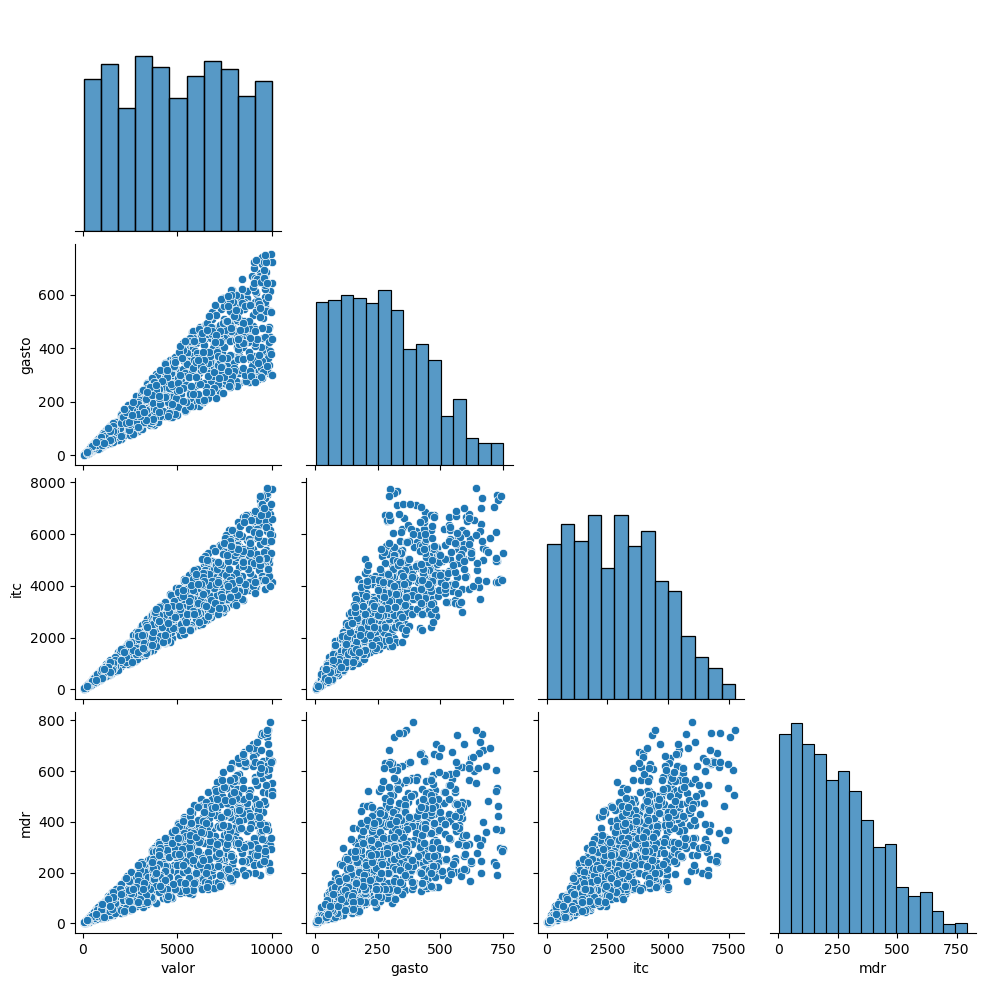

In [3]:
sns.pairplot(df, corner=True)

In [4]:
# Calculando a média e o desvio padrão da coluna 'Valor'
media_valor = df['valor'].mean()
desvio_padrao_valor = df['valor'].std()

# Definindo as condições para a nova coluna 'Classificação' com 5 faixas
def classificacao(valor):
    if valor < media_valor - 1.5 * desvio_padrao_valor:
        return 'Muito Baixo'
    elif valor < media_valor - 0.5 * desvio_padrao_valor:
        return 'Baixo'
    elif valor <= media_valor + 0.5 * desvio_padrao_valor:
        return 'Médio'
    elif valor <= media_valor + 1.5 * desvio_padrao_valor:
        return 'Alto'
    else:
        return 'Muito Alto'


# Adicionando a coluna 'Classificação'
df['fx_tx'] = df['valor'].apply(classificacao)

# Mostrando as primeiras linhas do DataFrame
print(df.head())


     cliente  valor       gasto          itc         mdr  fx_tx
0  cliente 1   2999  116.387874  2210.735434  132.647079  Baixo
1  cliente 2   3941  124.272830  2372.220237  261.754885  Médio
2  cliente 3   1989   90.605907  1442.333865  152.277919  Baixo
3  cliente 4   2618  159.476093  1263.887701  122.119755  Baixo
4  cliente 5   8452  602.308662  6646.286922  208.338707   Alto


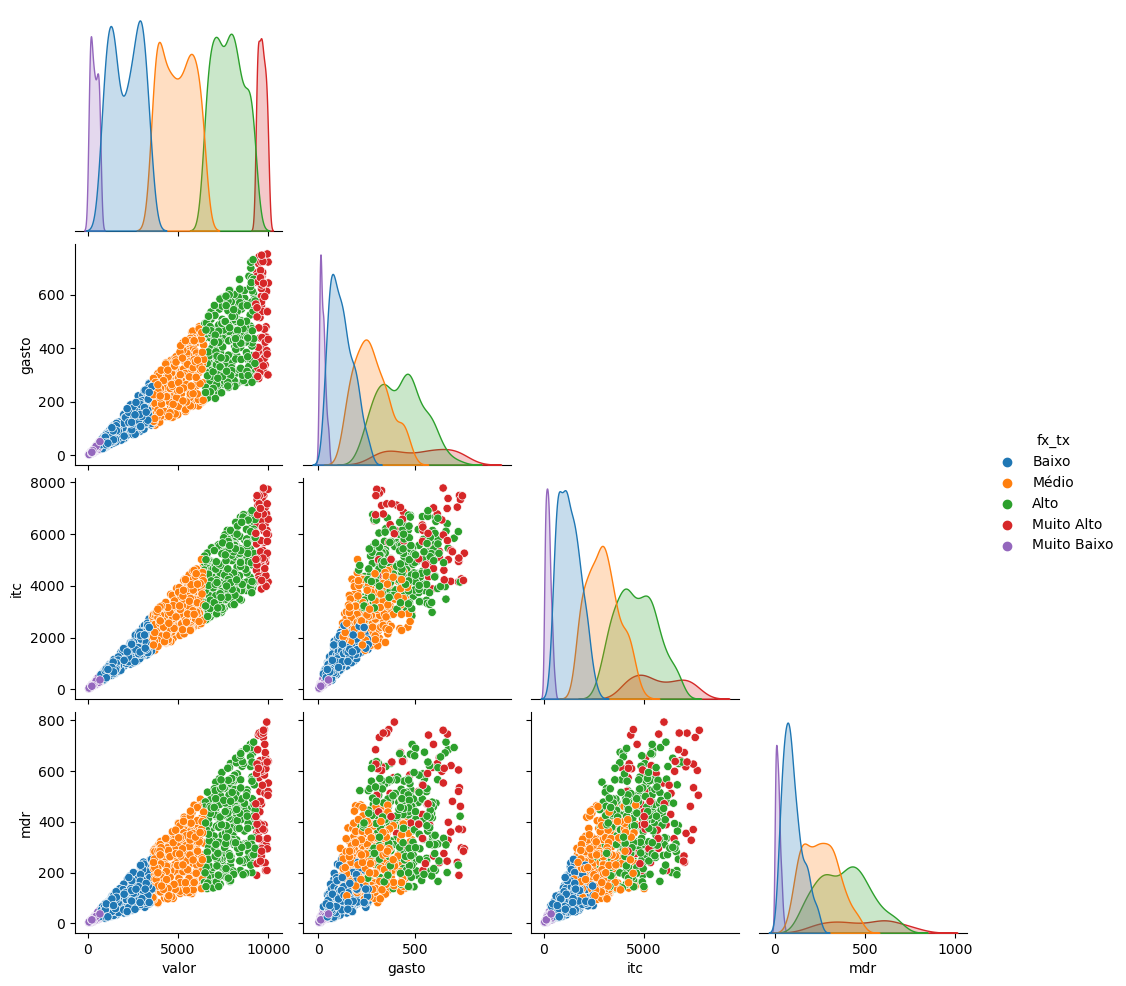

In [5]:
sns.pairplot(df, corner=True, hue='fx_tx')

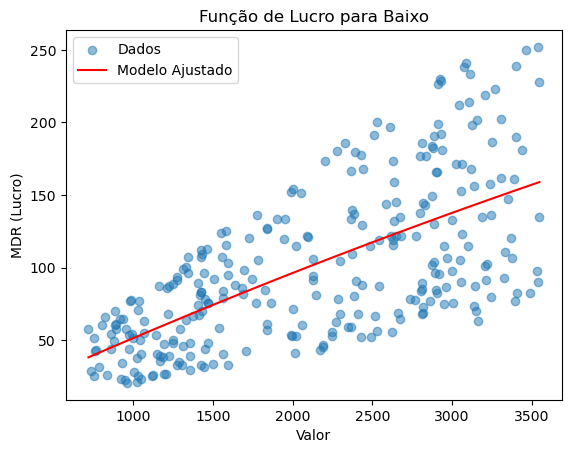

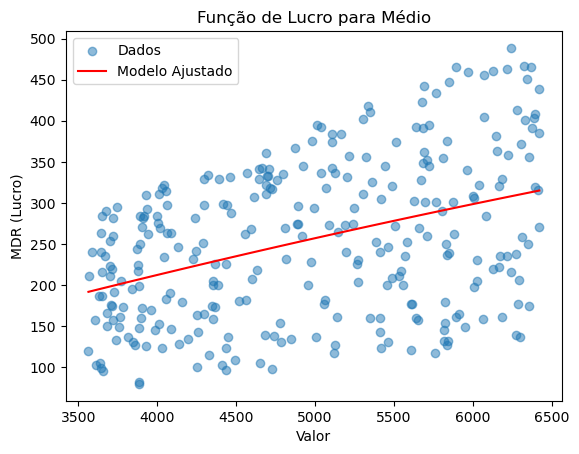

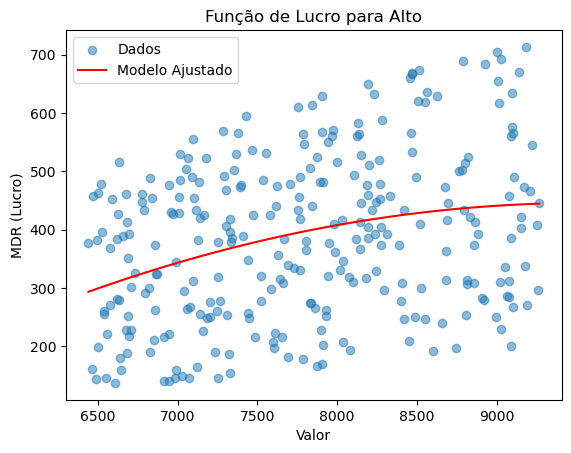

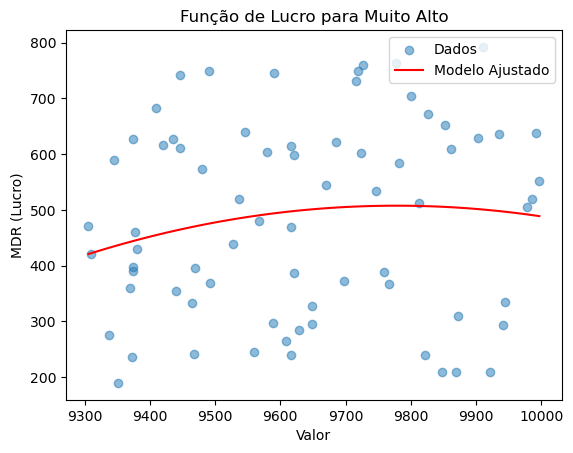

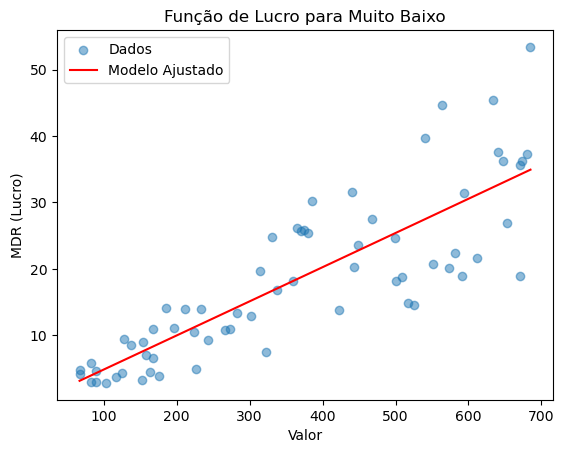

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Exemplo de função para ajustar um modelo de regressão linear ou polinomial para cada faixa de classificação
def ajustar_modelo(df, grau=1):
    X = df[['valor']].values
    y = df['mdr'].values
    
    # Ajuste polinomial de grau especificado
    poly = PolynomialFeatures(degree=grau)
    X_poly = poly.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X_poly, y)
    
    return model, poly

# Visualização das funções de lucro
def plotar_resultados(df, modelo, poly, titulo):
    X = np.linspace(df['valor'].min(), df['valor'].max(), 100).reshape(-1, 1)
    X_poly = poly.transform(X)
    y_pred = modelo.predict(X_poly)
    
    plt.scatter(df['valor'], df['mdr'], alpha=0.5, label='Dados')
    plt.plot(X, y_pred, color='red', label='Modelo Ajustado')
    plt.title(titulo)
    plt.xlabel('Valor')
    plt.ylabel('MDR (Lucro)')
    plt.legend()
    plt.show()

# Ajuste e plotagem para cada faixa de classificação
for classificacao in df['fx_tx'].unique():
    df_faixa = df[df['fx_tx'] == classificacao]
    modelo, poly = ajustar_modelo(df_faixa, grau=2)  # Ajuste de grau 2 (polinomial)
    plotar_resultados(df_faixa, modelo, poly, f'Função de Lucro para {classificacao}')


In [7]:
# Função para calcular o lucro estimado para um cliente usando o modelo ajustado
def calcular_mdr_estimado(modelo, poly, valor):
    valor_poly = poly.transform([[valor]])
    mdr_est = modelo.predict(valor_poly)[0]
    return mdr_est

# Adicionando uma nova coluna para o lucro estimado e a comparação
df['mdr_est'] = np.nan  # Inicializa a coluna 'mdr_est' vazia
df['comparacao'] = ''   # Inicializa a coluna 'comparacao' vazia

for classificacao in df['fx_tx'].unique():
    df_faixa = df[df['fx_tx'] == classificacao]
    modelo, poly = ajustar_modelo(df_faixa, grau=2)  # Reutilizando a função de ajuste de modelo
    
    # Calculando o mdr estimado e comparando com o real
    df.loc[df['fx_tx'] == classificacao, 'mdr_est'] = df_faixa['valor'].apply(lambda x: calcular_mdr_estimado(modelo, poly, x))
    df.loc[df['fx_tx'] == classificacao, 'comparacao'] = np.where(
        df_faixa['mdr'] > df_faixa['mdr_est'], 'Acima', 
        np.where(df_faixa['mdr'] < df_faixa['mdr_est'], 'Abaixo', 'Na Média')
    )

# Mostrando as primeiras linhas do DataFrame com as novas colunas
print(df.head())


     cliente  valor       gasto          itc         mdr  fx_tx     mdr_est  \
0  cliente 1   2999  116.387874  2210.735434  132.647079  Baixo  137.699890   
1  cliente 2   3941  124.272830  2372.220237  261.754885  Médio  209.549084   
2  cliente 3   1989   90.605907  1442.333865  152.277919  Baixo   95.870089   
3  cliente 4   2618  159.476093  1263.887701  122.119755  Baixo  122.337104   
4  cliente 5   8452  602.308662  6646.286922  208.338707   Alto  426.508019   

  comparacao  
0   Na Média  
1   Na Média  
2   Na Média  
3   Na Média  
4   Na Média  


In [14]:
df.groupby('fx_tx').count()

,cliente,valor,gasto,itc,mdr,mdr_est,comparacao
fx_tx,,,,,,,
Alto,287,287,287,287,287,287,287
Baixo,285,285,285,285,285,285,285
Muito Alto,72,72,72,72,72,72,72
Muito Baixo,66,66,66,66,66,66,66
Médio,290,290,290,290,290,290,290


In [11]:
df['fx_tx'].unique()

array(['Baixo', 'Médio', 'Alto', 'Muito Alto', 'Muito Baixo'],
      dtype=object)

In [12]:
order = ['Muito Baixo', 'Baixo', 'Médio', 'Alto', 'Muito Alto']

In [13]:
pd.Categorical(df['fx_tx'], categories=order, ordered=True)

['Baixo', 'Médio', 'Baixo', 'Baixo', 'Alto', ..., 'Alto', 'Médio', 'Alto', 'Muito Baixo', 'Médio']
Length: 1000
Categories (5, object): ['Muito Baixo' < 'Baixo' < 'Médio' < 'Alto' < 'Muito Alto']

In [17]:
df.groupby('fx_tx').count().reindex(order)

,cliente,valor,gasto,itc,mdr,mdr_est,comparacao
fx_tx,,,,,,,
Muito Baixo,66,66,66,66,66,66,66
Baixo,285,285,285,285,285,285,285
Médio,290,290,290,290,290,290,290
Alto,287,287,287,287,287,287,287
Muito Alto,72,72,72,72,72,72,72
